In [1]:
import torch
from torch import nn

In [22]:
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True

In [227]:
!nvidia-smi

Tue Nov 15 12:51:44 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 517.48       Driver Version: 517.48       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:06:00.0  On |                  N/A |
| 27%   49C    P0    31W / 125W |   2545MiB /  6144MiB |      8%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Exercise 1

In [6]:
v = torch.tensor([
    [10, 2, -3, 6, 11],
    [-5, 6, 8, 8, 0],
    [9, -1, 1, 2, 1],
    [6, 0, 1, 3, -4]
])

w = torch.ones_like(v)

print(v + w)
print(v - w)

tensor([[11,  3, -2,  7, 12],
        [-4,  7,  9,  9,  1],
        [10,  0,  2,  3,  2],
        [ 7,  1,  2,  4, -3]])
tensor([[ 9,  1, -4,  5, 10],
        [-6,  5,  7,  7, -1],
        [ 8, -2,  0,  1,  0],
        [ 5, -1,  0,  2, -5]])


# Exercise 2

In [214]:
A = torch.tensor([
    [1, -4, 2, 5],
    [10, -1, 4, 9]
], dtype=torch.float32)

x = torch.tensor([1, 2, -3, 5], dtype=torch.float32, requires_grad=True).t()

print(A.shape)
print(x.shape)

torch.Size([2, 4])
torch.Size([4])


In [224]:
# B = ||A||F Ax
B = torch.norm(A) * A @ x
B

tensor([187.4460, 640.4405], grad_fn=<MvBackward0>)

In [225]:
# f = 2B[1](x * x)
f = 2.0 * B[1] * (x * x)
f

tensor([ 1280.8810,  5123.5239, 11527.9287, 32022.0254],
       grad_fn=<MulBackward0>)

In [226]:
# nabla x f
nabla_x_f = torch.autograd.grad(f, x)


RuntimeError: grad can be implicitly created only for scalar outputs

# Exercise 3

In [235]:
def synthetic_data(w, b):  
    """Generate y = Xw + b + noise."""
    X = torch.rand(250).reshape(-1, 1)
    y = X @ w + b + torch.rand(250) / 4
    return X, y.reshape(-1, 1)

In [236]:
features, labels = synthetic_data(torch.tensor([2.0]), 3)

In [237]:
print('Features:', features[0], '\nLabel:', labels[0])

Features: tensor([0.6599]) 
Label: tensor([4.5476])


In [238]:
def load_array(data_arrays, batch_size, is_train=True): 
    """Construct a PyTorch data iterator."""
    dataset = torch.utils.data.TensorDataset(*data_arrays)
    return torch.utils.data.DataLoader(dataset, batch_size, shuffle=is_train)

In [239]:
batch_size = 50
data_iter = load_array((features, labels), batch_size)

In [249]:
ex3_net = nn.Sequential(
    nn.Linear(1, 1)
)

In [250]:
ex3_net[0].weight.data.fill_(1)
ex3_net[0].bias.data.fill_(0)

tensor([0.])

In [254]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(ex3_net.parameters(), lr=0.05)

In [255]:
num_epochs = 10
for epoch in range(num_epochs):
    for X, y in data_iter:
        l = loss_fn(ex3_net(X), y)
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
    l = loss_fn(ex3_net(features), labels)
    print(f'Epoch {epoch + 1}, Loss {l:f}')

Epoch 1, Loss 3.371701
Epoch 2, Loss 0.870068
Epoch 3, Loss 0.239381
Epoch 4, Loss 0.079658
Epoch 5, Loss 0.037564
Epoch 6, Loss 0.026381
Epoch 7, Loss 0.022551
Epoch 8, Loss 0.020736
Epoch 9, Loss 0.019546
Epoch 10, Loss 0.018565


# Exercise 4

## Data

In [76]:
from torchvision import transforms
from torchvision.datasets import FashionMNIST, MNIST, CIFAR100
from torch.utils.data import DataLoader, random_split, Subset
from torch import Generator

def load_data(Mnist: MNIST, batch_size: int, split: list[int, int], resize: int | None=None) -> tuple[DataLoader, DataLoader, DataLoader]:
    """Download a dataset and then load it into memory."""
    trans: list[transforms.ToTensor] = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
        
    transform: transforms.Compose = transforms.Compose(trans)
    
    mnist_train: MNIST = Mnist(root="../data", train=True, transform=transform, download=True)
    mnist_test: MNIST = Mnist(root="../data", train=False, transform=transform, download=True)
    
    mnist_train, mnist_val = random_split(mnist_train, split, generator=Generator().manual_seed(42))
    
    return (
        DataLoader(mnist_train, batch_size, shuffle=True, num_workers=2),
        DataLoader(mnist_val, batch_size, shuffle=False, num_workers=2),
        DataLoader(mnist_test, batch_size, shuffle=False, num_workers=2)
    )

In [114]:
data = load_data(CIFAR100, 200, [25000, 25000])

Files already downloaded and verified
Files already downloaded and verified


In [115]:
data_train, data_val, data_test = data

In [112]:
# print(next(iter(data_train))[0].shape)

torch.Size([200, 3, 32, 32])


## Model

In [124]:
ex4_net1 = nn.Sequential(
    nn.Flatten(),
    nn.Linear(3 * 32 * 32, 512), nn.ReLU()
)

ex4_net2 = nn.Sequential(
    nn.Linear(512, 100)
)

def init_net1(w):
    if type(w) == nn.Linear:
        nn.init.normal_(w.weight, std=0.01)
        
def init_net2(w):
    if type(w) == nn.Linear:
        nn.init.xavier_uniform_(w.weight)
        
ex4_net1.apply(init_net1)
ex4_net2.apply(init_net2)

Sequential(
  (0): Linear(in_features=512, out_features=100, bias=True)
)

In [125]:
ex4_model = nn.Sequential(
    ex4_net1,
    ex4_net2
)

In [126]:
def test_net(net: nn.Module, x: torch.Tensor):
    for layer in net:
        x = layer(x)
        print(f'{layer.__class__.__name__: <15}\t->\t{x.shape}')

In [127]:
test_net(ex4_model, torch.randn(1, 3, 32, 32))

Sequential     	->	torch.Size([1, 512])
Sequential     	->	torch.Size([1, 100])


## Train

In [193]:
torch.cuda.device_count()

0

In [86]:
def try_gpu(i=0):
    """Return gpu(i) if exists, otherwise return cpu()."""
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')

In [145]:
def evaluate_accuracy(net, data_iter, loss, device):
    """Compute the accuracy for a model on a dataset."""
    net.eval()  # Set the model to evaluation mode

    total_loss = 0
    total_hits = 0
    total_samples = 0
    with torch.no_grad():
        for X, y in data_iter:
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            total_loss += float(l)
            total_hits += sum(net(X).argmax(axis=1).type(y.dtype) == y)
            total_samples += y.numel()
    return float(total_loss) / len(data_iter), float(total_hits) / total_samples  * 100

In [146]:
def train_epoch(net, train_iter, loss, optimizer, device):  
    # Set the model to training mode
    net.train()
    # Sum of training loss, sum of training correct predictions, no. of examples
    total_loss = 0
    total_hits = 0
    total_samples = 0
    for X, y in train_iter:
        # Compute gradients and update parameters
        X, y = X.to(device), y.to(device)
        y_hat = net(X)
        l = loss(y_hat, y)
        # Using PyTorch built-in optimizer & loss criterion
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
        total_loss += float(l)
        total_hits += sum(y_hat.argmax(axis=1).type(y.dtype) == y)
        total_samples += y.numel()
    # Return training loss and training accuracy
    return float(total_loss) / len(train_iter), float(total_hits) / total_samples  * 100

In [147]:
def train(net, train_iter, val_iter, num_epochs, loss, optimizer, device):
    """Train a model."""
    train_loss_all = []
    train_acc_all = []
    val_loss_all = []
    val_acc_all = []
    
    print('Training on', device)
    net.to(device)
    
    for epoch in range(num_epochs):
        train_loss, train_acc = train_epoch(net, train_iter, loss, optimizer, device)
        train_loss_all.append(train_loss)
        train_acc_all.append(train_acc)
        val_loss, val_acc = evaluate_accuracy(net, val_iter, loss, device)
        val_loss_all.append(val_loss)
        val_acc_all.append(val_acc)
        print(f'Epoch {epoch + 1}, Train loss {train_loss:.2f}, Train accuracy {train_acc:.2f}, Validation loss {val_loss:.2f}, Validation accuracy {val_acc:.2f}')

    return train_loss_all, train_acc_all, val_loss_all, val_acc_all

In [128]:
lr, num_epochs = 0.2, 10

optimizer = torch.optim.SGD(ex4_model.parameters(), lr=lr)
loss = nn.CrossEntropyLoss()

data_all = train(
    ex4_model,
    data_train,
    data_val,
    num_epochs,
    loss,
    optimizer,
    try_gpu())

Training on cpu
Epoch 1, Train loss 4.38, Train accuracy 3.96, Validation loss 4.17, Validation accuracy 5.80
Epoch 2, Train loss 4.06, Train accuracy 7.75, Validation loss 3.96, Validation accuracy 9.29
Epoch 3, Train loss 3.92, Train accuracy 10.22, Validation loss 3.87, Validation accuracy 11.20
Epoch 4, Train loss 3.81, Train accuracy 11.95, Validation loss 3.78, Validation accuracy 12.72
Epoch 5, Train loss 3.73, Train accuracy 13.43, Validation loss 3.76, Validation accuracy 13.38
Epoch 6, Train loss 3.68, Train accuracy 13.94, Validation loss 3.75, Validation accuracy 12.77
Epoch 7, Train loss 3.63, Train accuracy 15.09, Validation loss 3.62, Validation accuracy 15.74
Epoch 8, Train loss 3.58, Train accuracy 15.88, Validation loss 3.74, Validation accuracy 13.10
Epoch 9, Train loss 3.53, Train accuracy 16.66, Validation loss 3.62, Validation accuracy 15.56
Epoch 10, Train loss 3.50, Train accuracy 16.99, Validation loss 3.61, Validation accuracy 15.94


In [134]:
test_loss, test_acc = evaluate_accuracy(ex4_model, data_test, loss, try_gpu())
print(f'Test loss {test_loss:.2f}, Test accuracy {test_acc:.2f}')

Test loss 3.61, Test accuracy 15.76


## Plotting

In [149]:
## Plotting
import matplotlib.pyplot as plt
def plot_loss(train_loss_all, val_loss_all):
    epochs = range(1, len(train_loss_all) + 1) 
    plt.plot(epochs, train_loss_all, 'bo', label='Training loss') 
    plt.plot(epochs, val_loss_all, 'b', label='Validation loss') 
    plt.title('Training and validation loss') 
    plt.xlabel('Epochs') 
    plt.ylabel('Loss') 
    plt.legend()  
    plt.show()
def plot_accuracy(train_acc_all, val_acc_all):
    epochs = range(1, len(train_acc_all) + 1)
    plt.plot(epochs, train_acc_all, 'bo', label='Training acc')
    plt.plot(epochs, val_acc_all, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs') 
    plt.ylabel('Accuracy') 
    plt.legend()
    plt.show()

In [150]:
train_loss_all, train_acc_all, val_loss_all, val_acc_all = data_all

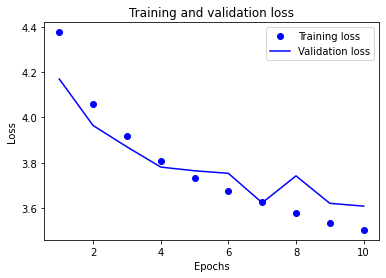

In [151]:
plot_loss(train_loss_all, val_loss_all)

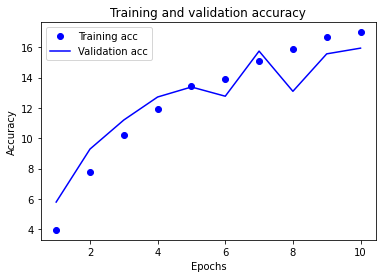

In [152]:
plot_accuracy(train_acc_all, val_acc_all)

# Exercise 5

In [73]:
X = torch.randn(1, 3, 4, 4)
K = torch.tensor([[
    [[1, 14],
     [2, -3]],
    [[10, 2],
     [4, 5]],
    [[1, 0],
     [3, 20]],
]], dtype=torch.float32)

In [74]:
print(X.shape)
print(K.shape)

torch.Size([1, 3, 4, 4])
torch.Size([1, 3, 2, 2])


In [75]:
nn.functional.conv2d(X, K)

tensor([[[[-19.1960, -25.2159, -36.0845],
          [ 16.6481,  -0.2579, -20.2250],
          [-55.5933, -12.9544, -30.1362]]]])

# Exercise 6

## Data

In [135]:
data = load_data(CIFAR100, 150, [6000, 44000])

Files already downloaded and verified
Files already downloaded and verified


In [136]:
data_train, data_val, data_test = data

## Model

In [141]:
class ConvBlock(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.lAvgPool = nn.AvgPool2d(kernel_size=(2, 2), stride=16)
        self.lConv = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(1, 1))
        self.lBatchNorm = nn.BatchNorm2d(num_features=32)
        self.lReLU = nn.ReLU()
        
        self.mConv = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(1, 1), stride=16)
        self.mBatchNorm = nn.BatchNorm2d(num_features=32)
        self.mReLU = nn.ReLU()
        
        self.rConv = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(1, 1))
        self.rReLU = nn.ReLU()
        
        self.rlConv = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=(1, 3), stride=16)
        self.rlReLU = nn.ReLU()
        
        self.rrConv = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=(3, 1), stride=16)
        self.rrReLU = nn.ReLU()
        
    def forward(self, x):
        l = self.lAvgPool(x)
        l = self.lConv(l)
        l = self.lBatchNorm(l)
        l = self.lReLU(l)
        
        m = self.mConv(x)
        m = self.mBatchNorm(m)
        m = self.mReLU(m)
        
        r = self.rConv(x)
        r = self.rReLU(r)
        
        rl = self.rlConv(r)
        rl = self.rlReLU(rl)
        
        rr = self.rrConv(r)
        rr = self.rrReLU(rr)
        
        return torch.cat((l, m, rl, rr), dim=1)

In [142]:
ex6_net = nn.Sequential(
    ConvBlock(),
    nn.Flatten(),
    nn.Linear(512, 100)
)

In [143]:
test_net(ex6_net, torch.rand(1, 3, 32, 32))

ConvBlock      	->	torch.Size([1, 128, 2, 2])
Flatten        	->	torch.Size([1, 512])
Linear         	->	torch.Size([1, 100])


## Training

In [194]:
torch.cuda.is_available()

False

In [153]:
lr, num_epochs = 0.5, 10

optimizer = torch.optim.SGD(ex6_net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss()

data_all = train(
    ex6_net,
    data_train,
    data_val,
    num_epochs,
    loss,
    optimizer,
    try_gpu())

# sorry, it is too slow on the CPU

Training on cpu
Epoch 1, Train loss 4.33, Train accuracy 4.60, Validation loss 4.27, Validation accuracy 5.78
Epoch 2, Train loss 4.04, Train accuracy 7.43, Validation loss 4.14, Validation accuracy 6.58
Epoch 3, Train loss 3.94, Train accuracy 9.22, Validation loss 4.29, Validation accuracy 5.52
Epoch 4, Train loss 3.87, Train accuracy 9.67, Validation loss 4.05, Validation accuracy 8.62
Epoch 5, Train loss 3.82, Train accuracy 10.62, Validation loss 4.05, Validation accuracy 8.48
Epoch 6, Train loss 3.78, Train accuracy 11.65, Validation loss 4.11, Validation accuracy 8.27


KeyboardInterrupt: 

In [ ]:
test_loss, test_acc = evaluate_accuracy(ex6_net, data_test, loss, try_gpu())
print(f'Test loss {test_loss:.2f}, Test accuracy {test_acc:.2f}')

## Plotting

In [ ]:
train_loss_all, train_acc_all, val_loss_all, val_acc_all = data_all

In [ ]:
plot_loss(train_loss_all, val_loss_all)

In [ ]:
plot_accuracy(train_acc_all, val_acc_all)